Sam Gordon <br> 
May 12, 2025 <br> 
Final Project Submittal
Urban Data Science & Smart Cities <br>
URSP688Y Spring 2025<br>
Instructor: Chester Harvey <br> 
<br> 
Urban Studies & Planning <br>
National Center for Smart Growth <br>
University of Maryland

# The Red Line Divide: Examining Housing Affordability and Demographic Changes Near Red Line Metrorail Stations in Montgomery County, Maryland



#### Core Question:
##### How has housing affordability changed near Red Line Metrorail stations in Maryland over the past decade? On top of that, how about racial demographics? 

##### The Python code written in this notebook can be used to graphically analyze the above questions to support planning policy decisions and priorities. 


### # Time to import and clean some Census data and make a master dataframe!

In [1]:
import pandas as pd
import os
os.makedirs("output", exist_ok=True)
import re

# Define path to raw Census data folder
data_dir = os.path.join(os.getcwd(), "Census_Data")

# File paths
# The three housing indicators of Median Household Income (MHI), Median Gross Rent, and Median Home Value to start
files = {
    "MHI_2013": os.path.join(data_dir, "2013 5-year MHI.csv"),
    "MHI_2023": os.path.join(data_dir, "2023 5-year MHI.csv"),
    "Rent_2013": os.path.join(data_dir, "2013 5-year Median Gross Rent.csv"),
    "Rent_2023": os.path.join(data_dir, "2023 5-year Median Gross Rent.csv"),
    "Value_2013": os.path.join(data_dir, "2013 5-year Median Value.csv"),
    "Value_2023": os.path.join(data_dir, "2023 5-year Median Value.csv")
}

# CLEAN BOTH 2023 AND 2013 ACS FILES

# Clean 2023-format ACS file
def clean_acs_2023_format(filepath, value_col_name):
    df = pd.read_csv(filepath)
    data_row = df.iloc[0]
    records = []

    for col_name, value in data_row.items():
        if "Census Tract" in col_name and "!!Estimate" in col_name:
            match = re.search(r"Census Tract ([\d\.]+);", col_name)
            if match:
                tract = match.group(1).replace(".", "").zfill(6)
                geoid = "24031" + tract
                try:
                    val = float(str(value).replace(",", "").replace("+", "").replace("$", ""))
                    records.append({"GEOID": geoid, value_col_name: val})
                except:
                    continue
    return pd.DataFrame(records)

# Clean 2013-format ACS file
def clean_acs_2013_format(filepath, value_col_name):
    df = pd.read_csv(filepath)
    data_row = df.iloc[0]
    records = []

    for col_name, value in data_row.items():
        if "Census Tract" in col_name and "!!Estimate" in col_name:
            match = re.search(r"Census Tract ([\d\.]+),", col_name)
            if match:
                tract = match.group(1).replace(".", "").zfill(6)
                geoid = "24031" + tract
                try:
                    val = float(str(value).replace(",", "").replace("+", "").replace("$", ""))
                    records.append({"GEOID": geoid, value_col_name: val})
                except:
                    continue
    return pd.DataFrame(records)

# Clean all 6 input files
mhi_2013 = clean_acs_2013_format(files["MHI_2013"], "MHI_2013")
mhi_2023 = clean_acs_2023_format(files["MHI_2023"], "MHI_2023")
rent_2013 = clean_acs_2013_format(files["Rent_2013"], "Rent_2013")
rent_2023 = clean_acs_2023_format(files["Rent_2023"], "Rent_2023")
value_2013 = clean_acs_2013_format(files["Value_2013"], "Value_2013")
value_2023 = clean_acs_2023_format(files["Value_2023"], "Value_2023")

# Merge all into one master DataFrame
master_df = (
    mhi_2013.merge(mhi_2023, on="GEOID", how="outer")
    .merge(rent_2013, on="GEOID", how="outer")
    .merge(rent_2023, on="GEOID", how="outer")
    .merge(value_2013, on="GEOID", how="outer")
    .merge(value_2023, on="GEOID", how="outer")
)

# Calculate percent change columns
master_df["Income_Change_%"] = ((master_df["MHI_2023"] - master_df["MHI_2013"]) / master_df["MHI_2013"]) * 100
master_df["Rent_Change_%"] = ((master_df["Rent_2023"] - master_df["Rent_2013"]) / master_df["Rent_2013"]) * 100
master_df["Value_Change_%"] = ((master_df["Value_2023"] - master_df["Value_2013"]) / master_df["Value_2013"]) * 100

# Export cleaned master sheet (updated version)
master_df.to_csv(os.path.join(data_dir, "Final_Tract-Level_Percent_Changes_Updated.csv"), index=False)

# Preview
master_df.head()


,GEOID,MHI_2013,MHI_2023,Rent_2013,Rent_2023,Value_2013,Value_2023,Income_Change_%,Rent_Change_%,Value_Change_%
0,24031007004,123173.0,183672.0,1328.0,1530.0,600200.0,811800.0,49.117095,15.210843,35.254915
1,24031007005,104648.0,197727.0,1637.0,1934.0,455100.0,700200.0,88.944844,18.142944,53.856295
2,24031007018,63355.0,100114.0,1058.0,1449.0,569600.0,857800.0,58.020677,36.956522,50.596910
3,24031007019,55833.0,57283.0,1208.0,1447.0,388700.0,597900.0,2.597030,19.784768,53.820427
4,24031007020,47904.0,67902.0,1208.0,1629.0,255400.0,386100.0,41.745992,34.850993,51.174628


### # Spatial Join of Maryland Census Tracts and Metrorail station locations to create buffered focus area:

In [2]:
# Import Metrorail station and census tract data, confirm CRS match
import geopandas as gpd
import matplotlib.pyplot as plt

# Load the GeoJSON files
metro_stations = gpd.read_file('Metro Stations/Maryland_Transit_-_WMATA_Metro_Stops.geojson')
census_tracts = gpd.read_file('Census Tracts/Maryland_Census_Boundaries_-_Census_Tracts_2020.geojson')

# Check the Coordinate Reference Systems (CRS)
print("Metro Stations CRS:", metro_stations.crs)
print("Census Tracts CRS:", census_tracts.crs)


Metro Stations CRS: EPSG:4326
Census Tracts CRS: EPSG:4326


In [3]:
# Create half-mile buffer around only Red Line Metro stations to capture those specific census tracts

# Filter to only Red Line stations
red_line_stations = metro_stations[metro_stations['MetroLine'] == 'red']

# Reproject both datasets to Maryland State Plane (in meters)
red_line_stations = red_line_stations.to_crs(epsg=26985)
census_tracts = census_tracts.to_crs(epsg=26985)

# Buffer stations by half a mile (~ 804.672 meters)
red_line_buffers = red_line_stations.copy()
red_line_buffers['geometry'] = red_line_buffers.buffer(804.672)

# Spatial Join: Identify census tracts that intersect with the half mile Red Line buffer
tracts_near_red_line = gpd.sjoin(census_tracts, red_line_buffers, how='inner', predicate='intersects')
 

In [4]:
# SAVE IT as "tracts_near_red_line"

# Save to GeoJSON
tracts_near_red_line.to_file('Metro Stations/Red_Line_Adjacent_Census_Tracts.geojson', driver='GeoJSON')

# Save to CSV (attribute data only, without geometry)
tracts_near_red_line.drop(columns='geometry').to_csv('Metro Stations/Red_Line_Adjacent_Census_Tracts.csv', index=False)


### # Create Context Maps

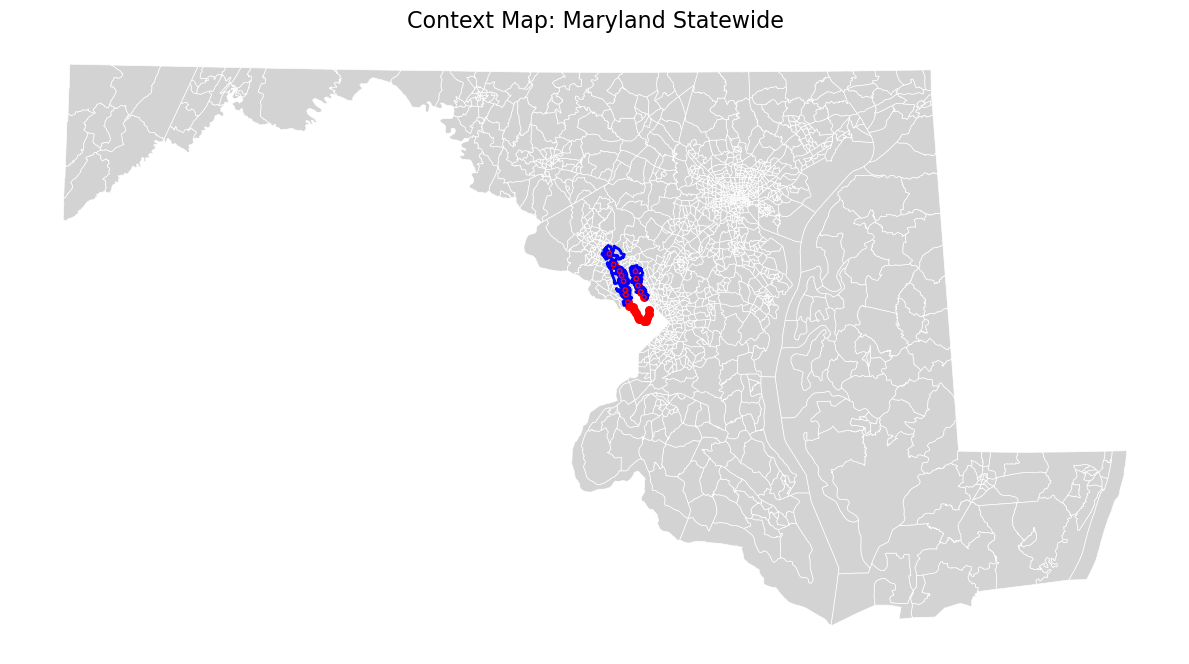

In [5]:
# Context in State of Maryland

# Set up the plot
fig, ax = plt.subplots(figsize=(12, 12))

# Plot all census tracts in light gray
census_tracts.to_crs(epsg=26985).plot(ax=ax, color='lightgray', edgecolor='white', linewidth=0.5)

# Plot only the Red Line half-mile buffers in transparent red
red_line_buffers.boundary.plot(ax=ax, color='red', linewidth=1)

# Plot Red Line stations as red points
red_line_stations.to_crs(epsg=26985).plot(ax=ax, color='red', markersize=30)

# Plot the buffered, half-mile census tracts in blue
tracts_near_red_line.to_crs(epsg=26985).plot(ax=ax, facecolor='none', edgecolor='blue', linewidth=2)

# Title and axes 
ax.set_title('Context Map: Maryland Statewide', fontsize=16)
ax.axis('off')

# Show and save plot
plt.tight_layout()
plt.savefig("output/01_context_map_statewide.png", dpi=300, bbox_inches="tight")
plt.show()


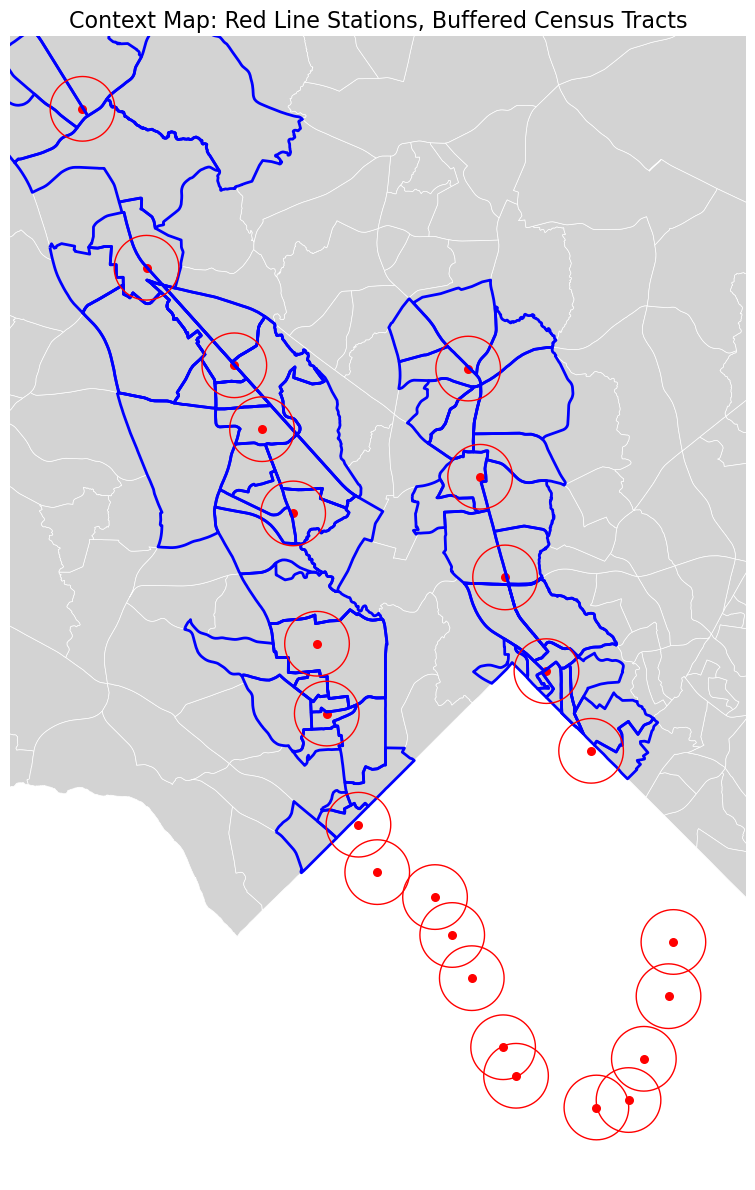

In [6]:
# Zoomed in to the focus area

# Get the total bounds of the red_line_buffers 
bounds = red_line_buffers.total_bounds
buffer = 1000  # Optional: add padding (in meters) around the bounds

# Set up the plot
fig, ax = plt.subplots(figsize=(12, 12))

# Plot everything same as before
census_tracts.plot(ax=ax, color='lightgray', edgecolor='white', linewidth=0.5)
red_line_buffers.boundary.plot(ax=ax, color='red', linewidth=1)
red_line_stations.plot(ax=ax, color='red', markersize=30)
tracts_near_red_line.plot(ax=ax, facecolor='none', edgecolor='blue', linewidth=2)

# Set the plot limits to zoom in
ax.set_xlim(bounds[0] - buffer, bounds[2] + buffer)
ax.set_ylim(bounds[1] - buffer, bounds[3] + buffer)

# Title and axes
ax.set_title('Context Map: Red Line Stations, Buffered Census Tracts', fontsize=16)
ax.axis('off')

# Show and save plot
plt.tight_layout()
plt.savefig("output/02_context_map_zoomed_redline.png", dpi=300, bbox_inches="tight")
plt.show()


### # Housing Indicator #1: Visualizing Change in Median Rent Near Maryland Red Line Stations Over Past Decade

In [7]:
import pandas as pd
import geopandas as gpd

# Load the Master Data Sheet
changes_df = pd.read_csv("Census_Data/Final_Tract-Level_Percent_Changes_Updated.csv")

# Drop rows where GEOID is missing or non-numeric
changes_df = changes_df[pd.to_numeric(changes_df["GEOID"], errors="coerce").notna()].copy()

# Ensure GEOID is 11-digit string
changes_df["GEOID"] = changes_df["GEOID"].astype(str).str.zfill(11)

# Load only Montgomery County census tracts
census_tracts = gpd.read_file("Census Tracts/Maryland_Census_Boundaries_-_Census_Tracts_2020.geojson")
census_tracts = census_tracts[census_tracts["COUNTYFP20"] == "031"]

# Match GEOID formatting
census_tracts["GEOID"] = census_tracts["GEOID20"].astype(str).str.zfill(11)

# Reproject
census_tracts = census_tracts.to_crs(epsg=26985)


In [8]:
# Create visual labels / call-out boxes for notable census tracts on all new maps

def label_tracts(ax, gdf, value_col, fontsize=9):
    for _, row in gdf.iterrows():
        x, y = row.geometry.centroid.x, row.geometry.centroid.y
        label = f"{row['GEOID'][-6:]}\n{row[value_col]:.2f}%"
        ax.annotate(
            label,
            xy=(x, y),
            xytext=(0, 0),
            textcoords="offset points",
            ha="center",
            fontsize=fontsize,
            color="black",
            backgroundcolor="white",
        )

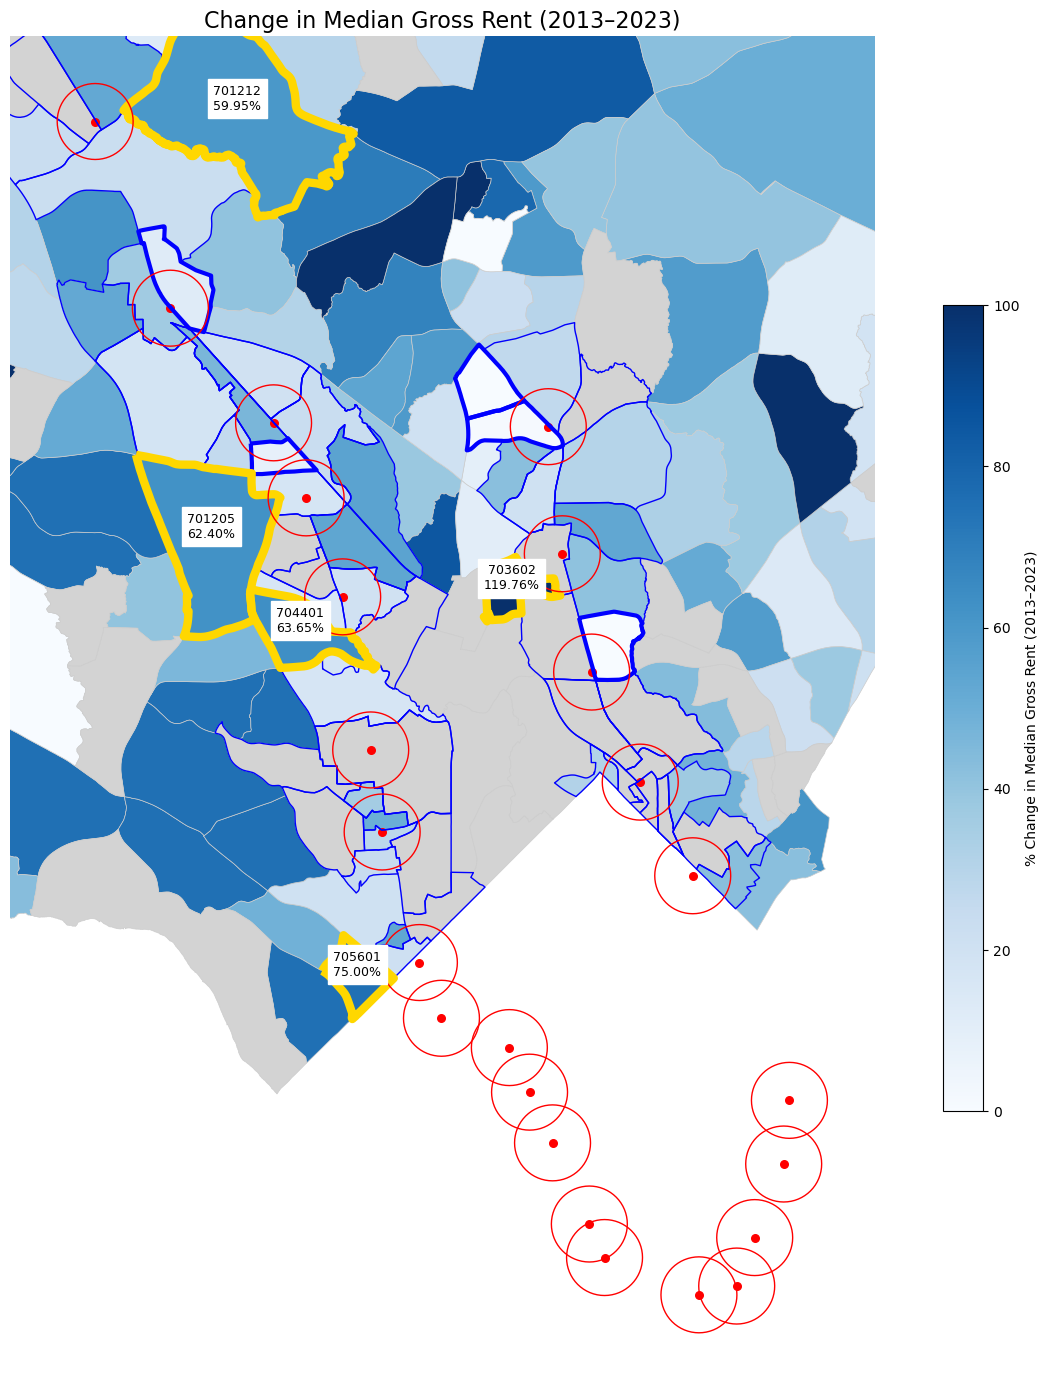

In [9]:
# MAPPING MEDIAN RENT CHANGES

# 0. Define Geodataframe
map_df = census_tracts.merge(changes_df[["GEOID", "Rent_Change_%"]], on="GEOID", how="left")

# 1. Align CRS (just in case)
map_df = map_df.to_crs(epsg=26985)
tracts_near_red_line = tracts_near_red_line.to_crs(epsg=26985)
red_line_buffers = red_line_buffers.to_crs(epsg=26985)
red_line_stations = red_line_stations.to_crs(epsg=26985)

# 2. Ensure consistent GEOID format (just in case)
tracts_near_red_line["GEOID"] = tracts_near_red_line["GEOID20"].astype(str).str.zfill(11)

# 3. Filter the buffer tracts
buffer_tracts = map_df[map_df["GEOID"].isin(tracts_near_red_line["GEOID"])]

# 4. Identify Top 5 and Bottom 5 Tracts
top_rent = buffer_tracts.nlargest(5, "Rent_Change_%")
bottom_rent = buffer_tracts.nsmallest(5, "Rent_Change_%")

top_tracts = map_df[map_df["GEOID"].isin(top_rent["GEOID"])]
bottom_tracts = map_df[map_df["GEOID"].isin(bottom_rent["GEOID"])]

# 5. Plot
fig, ax = plt.subplots(figsize=(14, 14))  # Slightly bigger for readability

map_df.plot(
    column="Rent_Change_%",
    cmap="Blues",
    linewidth=0.5,
    edgecolor="0.8",
    ax=ax,
    legend=True,
    vmax=100,
    vmin=0,
    legend_kwds={"label": "% Change in Median Gross Rent (2013–2023)", "shrink": 0.6},
    missing_kwds={"color": "lightgrey", "label": "No data"},
)

# Overlays for visual clarity
red_line_buffers.boundary.plot(ax=ax, color='red', linewidth=1)
red_line_stations.plot(ax=ax, color='red', markersize=30)
tracts_near_red_line.plot(ax=ax, facecolor='none', edgecolor='blue', linewidth=1)
bottom_tracts.plot(ax=ax, facecolor='none', edgecolor='blue', linewidth=3)
top_tracts.plot(ax=ax, facecolor='none', edgecolor='gold', linewidth=6)

# Labels
label_tracts(ax, top_tracts, value_col="Rent_Change_%")

# Zoom in on buffer area
bounds = red_line_buffers.total_bounds
buffer = 1000
ax.set_xlim(bounds[0] - buffer, bounds[2] + buffer)
ax.set_ylim(bounds[1] - buffer, bounds[3] + buffer)

# Title and axes
ax.set_title("Change in Median Gross Rent (2013–2023)", fontsize=16)
ax.axis("off")

# Show and save plot
plt.tight_layout()
plt.savefig("output/03_rent_change_percent.png", dpi=300, bbox_inches="tight")
plt.show()


### # Housing Indicator #2: Visualizing Change in Median Home Value Near Maryland Red Line Stations Over Past Decade

In [10]:
# Just change to "Value_Change_%" and "Greens" to make a new map for Home Value Change

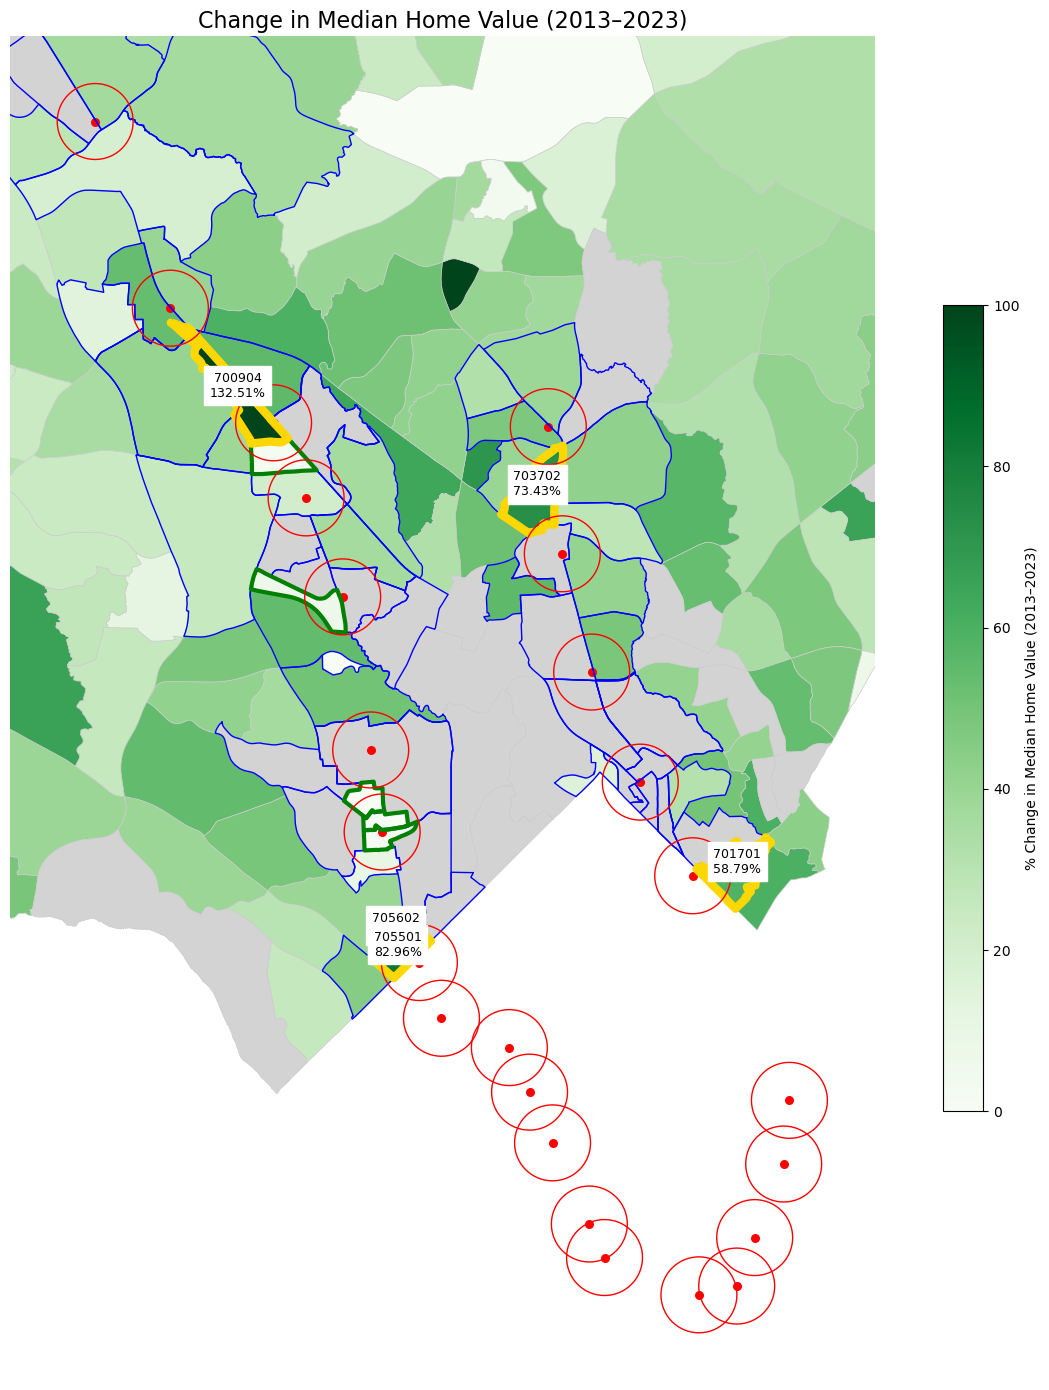

In [11]:
# MAPPING MEDIAN HOME VALUE CHANGES

# 0. Define Geodataframe
map_df = census_tracts.merge(changes_df[["GEOID", "Value_Change_%"]], on="GEOID", how="left")

# 1. Align CRS (just in case)
map_df = map_df.to_crs(epsg=26985)
tracts_near_red_line = tracts_near_red_line.to_crs(epsg=26985)
red_line_buffers = red_line_buffers.to_crs(epsg=26985)
red_line_stations = red_line_stations.to_crs(epsg=26985)

# 2. Ensure consistent GEOID format (just in case)
tracts_near_red_line["GEOID"] = tracts_near_red_line["GEOID20"].astype(str).str.zfill(11)

# 3. Filter the buffer tracts
buffer_tracts = map_df[map_df["GEOID"].isin(tracts_near_red_line["GEOID"])]

# 4. Identify Top 5 and Bottom 5 Tracts
top_value = buffer_tracts.nlargest(5, "Value_Change_%")
bottom_value = buffer_tracts.nsmallest(5, "Value_Change_%")

top_tracts = map_df[map_df["GEOID"].isin(top_value["GEOID"])]
bottom_tracts = map_df[map_df["GEOID"].isin(bottom_value["GEOID"])]

# 5. Plot
fig, ax = plt.subplots(figsize=(14, 14))  # Slightly bigger for readability

map_df.plot(
    column="Value_Change_%",
    cmap="Greens",
    linewidth=0.5,
    edgecolor="0.8",
    ax=ax,
    legend=True,
    vmax=100,
    vmin=0,
    legend_kwds={"label": "% Change in Median Home Value (2013–2023)", "shrink": 0.6},
    missing_kwds={"color": "lightgrey", "label": "No data"},
)

# Overlays for visual clarity
red_line_buffers.boundary.plot(ax=ax, color='red', linewidth=1)
red_line_stations.plot(ax=ax, color='red', markersize=30)
tracts_near_red_line.plot(ax=ax, facecolor='none', edgecolor='blue', linewidth=1)
bottom_tracts.plot(ax=ax, facecolor='none', edgecolor='green', linewidth=3)
top_tracts.plot(ax=ax, facecolor='none', edgecolor='gold', linewidth=6)

# Labels
label_tracts(ax, top_tracts, value_col="Value_Change_%")

# Zoom in on buffer area
bounds = red_line_buffers.total_bounds
buffer = 1000
ax.set_xlim(bounds[0] - buffer, bounds[2] + buffer)
ax.set_ylim(bounds[1] - buffer, bounds[3] + buffer)

# Title and axes
ax.set_title("Change in Median Home Value (2013–2023)", fontsize=16)
ax.axis("off")

# Show and save plot
plt.tight_layout()
plt.savefig("output/04_home_value_change_percent.png", dpi=300, bbox_inches="tight")
plt.show()


### # Housing Indicator #3: Visualizing Change in Median Household Income Near Maryland Red Line Stations Over Past Decade

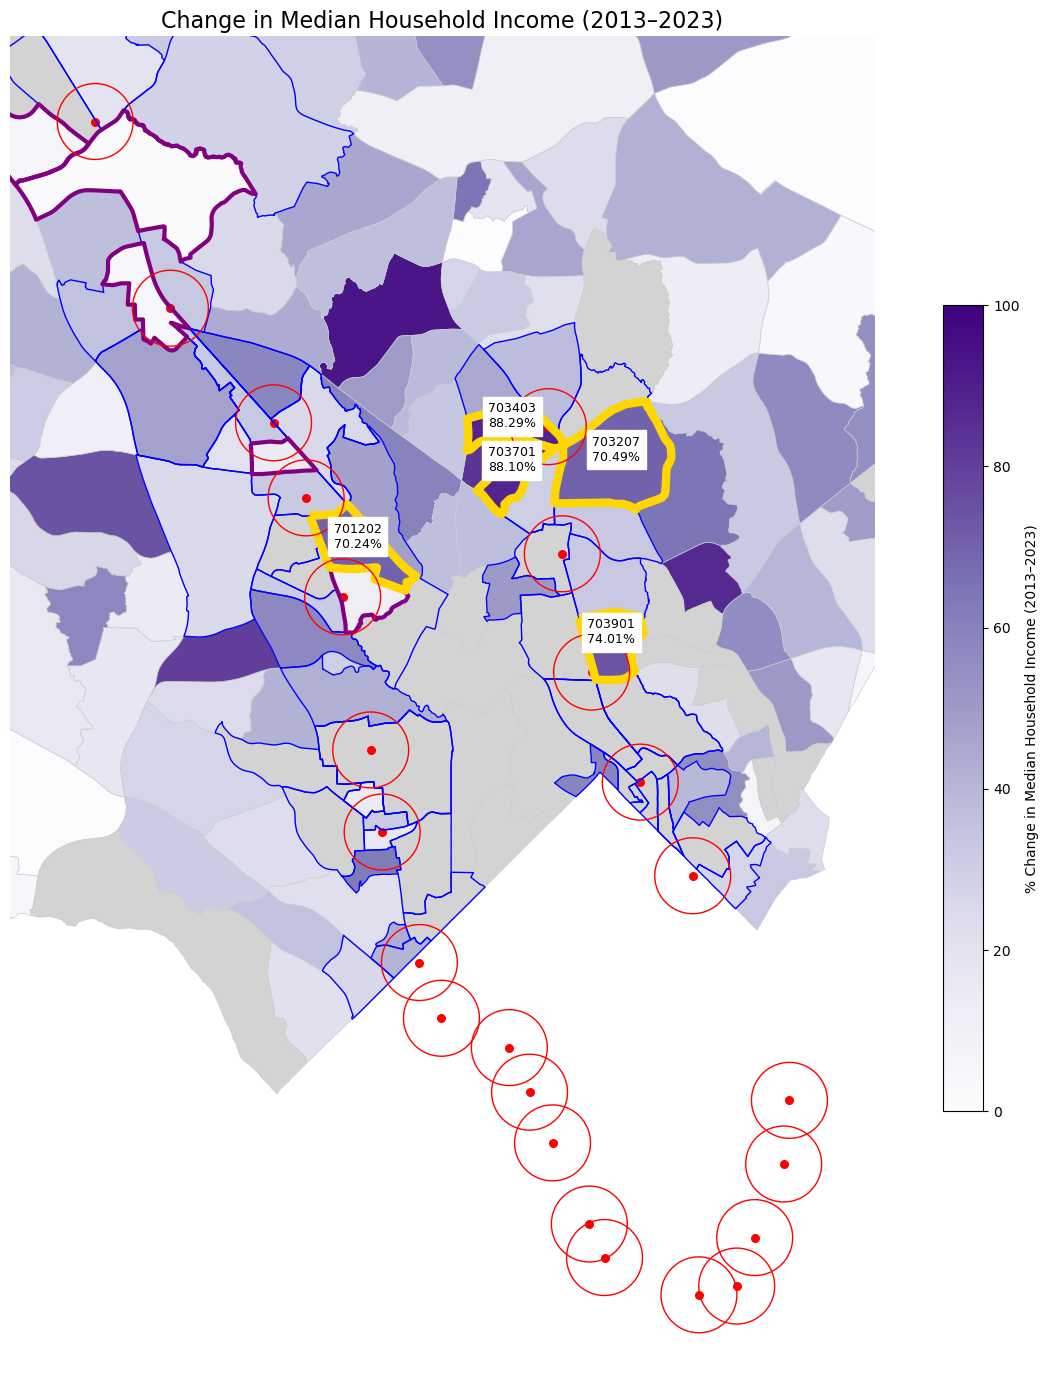

In [12]:
# 0. Define Geodataframe
map_df = census_tracts.merge(changes_df[["GEOID", "Income_Change_%"]], on="GEOID", how="left")

# 1. Align CRS
map_df = map_df.to_crs(epsg=26985)
tracts_near_red_line = tracts_near_red_line.to_crs(epsg=26985)
red_line_buffers = red_line_buffers.to_crs(epsg=26985)
red_line_stations = red_line_stations.to_crs(epsg=26985)

# 2. Ensure consistent GEOID format
tracts_near_red_line["GEOID"] = tracts_near_red_line["GEOID20"].astype(str).str.zfill(11)

# 3. Filter buffer tracts
buffer_tracts = map_df[map_df["GEOID"].isin(tracts_near_red_line["GEOID"])]

# 4. Top/bottom 5 tracts
top_mhi = buffer_tracts.nlargest(5, "Income_Change_%")
bottom_mhi = buffer_tracts.nsmallest(5, "Income_Change_%")

top_tracts = map_df[map_df["GEOID"].isin(top_mhi["GEOID"])]
bottom_tracts = map_df[map_df["GEOID"].isin(bottom_mhi["GEOID"])]

# 5. Plot
fig, ax = plt.subplots(figsize=(14, 14))  # Slightly bigger for readability

map_df.plot(
    column="Income_Change_%",
    cmap="Purples",
    linewidth=0.5,
    edgecolor="0.8",
    ax=ax,
    legend=True,
    vmax=100,
    vmin=0,
    legend_kwds={"label": "% Change in Median Household Income (2013–2023)", "shrink": 0.6},
    missing_kwds={"color": "lightgrey", "label": "No data"},
)

# Overlays
red_line_buffers.boundary.plot(ax=ax, color='red', linewidth=1)
red_line_stations.plot(ax=ax, color='red', markersize=30)
tracts_near_red_line.plot(ax=ax, facecolor='none', edgecolor='blue', linewidth=1)
bottom_tracts.plot(ax=ax, facecolor='none', edgecolor='purple', linewidth=3)
top_tracts.plot(ax=ax, facecolor='none', edgecolor='gold', linewidth=6)

# Labels
label_tracts(ax, top_tracts, value_col="Income_Change_%")

# Zoom in on buffer area
bounds = red_line_buffers.total_bounds
buffer = 1000
ax.set_xlim(bounds[0] - buffer, bounds[2] + buffer)
ax.set_ylim(bounds[1] - buffer, bounds[3] + buffer)

# Title and axes
ax.set_title("Change in Median Household Income (2013–2023)", fontsize=16)
ax.axis("off")

# Show and save plot
plt.tight_layout()
plt.savefig("output/05_mhi_change_percent.png", dpi=300, bbox_inches="tight")
plt.show()


### # Additional: Upload, clean, and visualize 2013 and 2023 Household Tenure data (Renter v. Owner ratios) 

In [13]:
tenure_2013 = pd.read_csv("Census_Data/2023_HouseholdTenure.csv")
tenure_2023 = pd.read_csv("Census_Data/2013_HouseholdTenure.csv")

def clean_tenure(df, year):
    # Rename first column to "Label"
    df = df.rename(columns={df.columns[0]: "Label"})

    # Strip whitespace and weird characters
    df["Label"] = df["Label"].str.strip().str.replace("\xa0", "", regex=False)

    # Standardize labels
    df["Label"] = df["Label"].replace({
        "Owner occupied": "Owner",
        "Renter occupied": "Renter",
        "Total:": "Total"
    })

    # Keep only Estimate columns
    estimate_cols = [col for col in df.columns if "Estimate" in col]
    df = df[["Label"] + estimate_cols]

    # Melt to long
    df_long = df.melt(id_vars=["Label"], var_name="Tract", value_name="Estimate")

    # Clean numbers
    df_long["Estimate"] = df_long["Estimate"].astype(str).str.replace(",", "").astype(float)

    # Extract tract number (e.g., "7045.01") from column name
    df_long["Tract_Number"] = df_long["Tract"].str.extract(r'Census Tract ([\d\.]+)')[0]

    # Convert to GEOID: prepend "24031" and remove the decimal
    df_long["GEOID"] = "24031" + df_long["Tract_Number"].str.replace(".", "", regex=False).str.zfill(6)

    # Group and pivot
    df_pivot = (
        df_long.groupby(["GEOID", "Label"])["Estimate"]
        .sum()
        .unstack("Label")
        .reset_index()
    )
    df_pivot.columns.name = None

    # Calculate percent columns
    df_pivot[f"OwnerPct_{year}"] = df_pivot["Owner"] / df_pivot["Total"] * 100
    df_pivot[f"RenterPct_{year}"] = df_pivot["Renter"] / df_pivot["Total"] * 100

    return df_pivot[["GEOID", f"OwnerPct_{year}", f"RenterPct_{year}"]]

In [14]:
# Clean 2013 and 2023
tenure13_clean = clean_tenure(tenure_2013, 2013)
tenure23_clean = clean_tenure(tenure_2023, 2023)

# Merge them
tenure_merged = tenure13_clean.merge(tenure23_clean, on="GEOID", how="inner")

# Add change columns
tenure_merged["OwnerChangePct"] = tenure_merged["OwnerPct_2023"] - tenure_merged["OwnerPct_2013"]
tenure_merged["RenterChangePct"] = tenure_merged["RenterPct_2023"] - tenure_merged["RenterPct_2013"]


In [15]:
master_df = pd.read_csv("Census_Data/Final_Tract-Level_Percent_Changes_Updated.csv")
master_df["GEOID"] = master_df["GEOID"].astype(str).str.zfill(11)
master_df = master_df.merge(tenure_merged, on="GEOID", how="left")
master_df.to_csv("Final_Tract-Level_Percent_Changes_Updated.csv", index=False)


In [16]:
# Sort by RenterChangePct descending (biggest increase)
top5_renters = tenure_merged.sort_values("RenterChangePct", ascending=False).head(5)

# Sort by RenterChangePct ascending (biggest decrease)
bottom5_renters = tenure_merged.sort_values("RenterChangePct", ascending=True).head(5)

top5_renters["ChangeType"] = "Top 5 Increases"
bottom5_renters["ChangeType"] = "Top 5 Decreases"

summary_df = pd.concat([top5_renters, bottom5_renters], ignore_index=True)

# Reorder columns for clarity
summary_df = summary_df[[
    "GEOID",
    "OwnerPct_2013", "OwnerPct_2023",
    "RenterPct_2013", "RenterPct_2023",
    "RenterChangePct",
    "ChangeType"
]]

In [17]:
# Show Top 5 tracts with highest renter % increase
print("Top 5 Tracts by Renter % Increase (2013–2023):")
display(top5_renters[["GEOID", "RenterPct_2013", "RenterPct_2023", "RenterChangePct"]])

# Show Bottom 5 tracts with biggest renter % decrease
print("\nBottom 5 Tracts by Renter % Decrease (2013–2023):")
display(bottom5_renters[["GEOID", "RenterPct_2013", "RenterPct_2023", "RenterChangePct"]])


Top 5 Tracts by Renter % Increase (2013–2023):


,GEOID,RenterPct_2013,RenterPct_2023,RenterChangePct
61,24031700819,11.918476,31.072027,19.153551
51,24031700720,26.065891,44.405286,18.339395
174,24031704503,6.787004,23.445693,16.658689
143,24031703207,53.594389,69.932432,16.338043
182,24031705602,44.345359,60.232476,15.887117



Bottom 5 Tracts by Renter % Decrease (2013–2023):


,GEOID,RenterPct_2013,RenterPct_2023,RenterChangePct
80,24031701002,31.675063,7.721713,-23.953350
124,24031701507,32.829809,10.675752,-22.154056
84,24031701007,63.636364,43.502825,-20.133539
96,24031701216,74.160501,56.288580,-17.871921
179,24031705501,83.248299,66.181127,-17.067172


### Mapping Change in Renter %

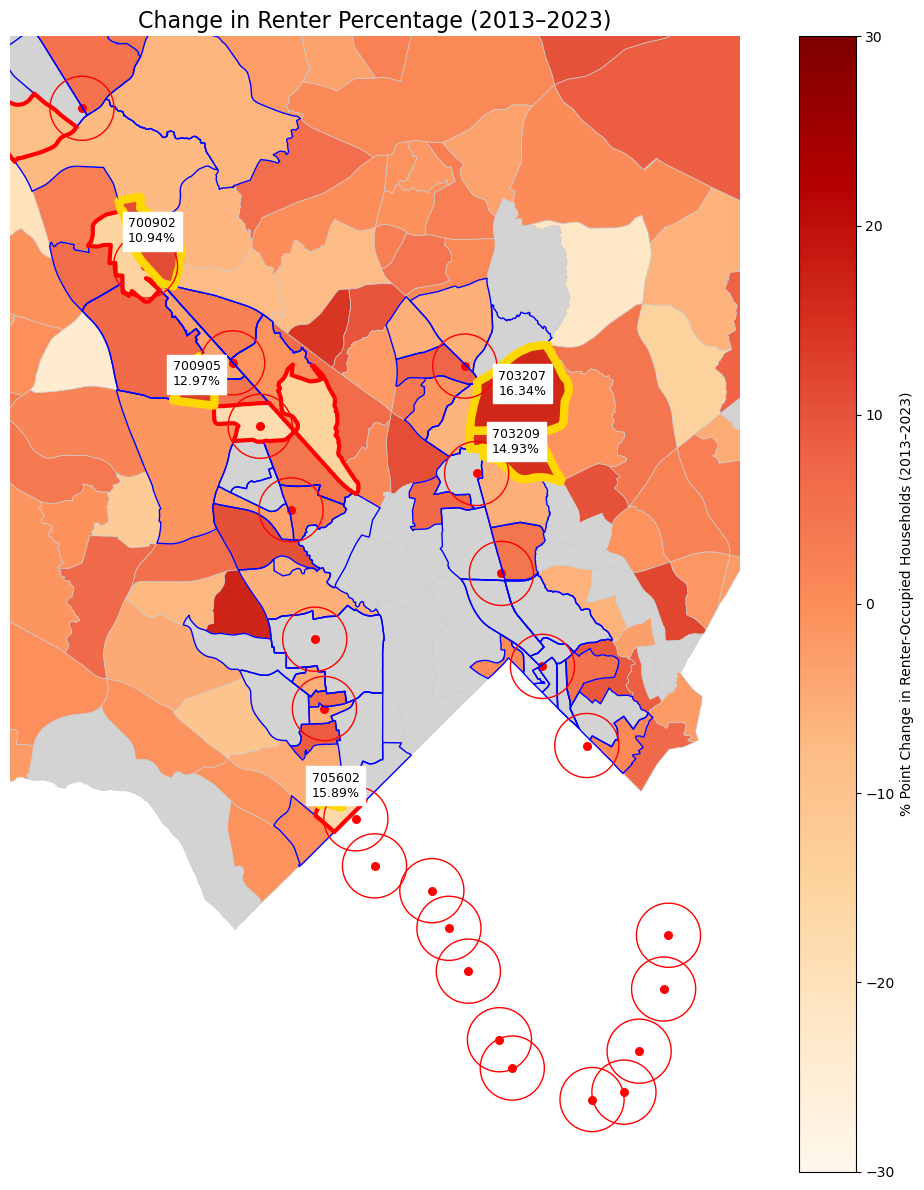

In [18]:
# Step 0: Join tenure change data into full map_df
map_df["GEOID"] = map_df["GEOID"].astype(str).str.zfill(11)
map_df = map_df.merge(tenure_merged[["GEOID", "RenterChangePct"]], on="GEOID", how="left")

# Step 1: Make sure buffer-zone tracts are clean
tracts_near_red_line["GEOID"] = tracts_near_red_line["GEOID20"].astype(str).str.zfill(11)

# Step 2: Filter to buffer-zone tracts
buffer_tracts = map_df[map_df["GEOID"].isin(tracts_near_red_line["GEOID"])]

# Step 3: Top and bottom 5 tracts by Renter % change
top_renters = buffer_tracts.nlargest(5, "RenterChangePct")
bottom_renters = buffer_tracts.nsmallest(5, "RenterChangePct")

# Step 4: Extract from full map_df
top_tracts = map_df[map_df["GEOID"].isin(top_renters["GEOID"])]
bottom_tracts = map_df[map_df["GEOID"].isin(bottom_renters["GEOID"])]

# Step 5: Plot
fig, ax = plt.subplots(figsize=(12, 12))
map_df.plot(
    column="RenterChangePct",
    cmap="OrRd",
    linewidth=0.5,
    ax=ax,
    edgecolor="0.8",
    legend=True,
    vmin=-30,
    vmax=30,
    legend_kwds={"label": "% Point Change in Renter-Occupied Households (2013–2023)"},
    missing_kwds={"color": "lightgrey", "label": "No data"},
)

# Step 6: Red Line overlays
map_df = map_df.to_crs(red_line_stations.crs)
if 'red_line_buffers' in locals():
    red_line_buffers.boundary.plot(ax=ax, color='red', linewidth=1)
if 'red_line_stations' in locals():
    red_line_stations.plot(ax=ax, color='red', markersize=30)
if 'tracts_near_red_line' in locals():
    tracts_near_red_line.plot(ax=ax, facecolor='none', edgecolor='blue', linewidth=1)

# Step 7: Callouts
bottom_tracts.plot(ax=ax, facecolor='none', edgecolor='red', linewidth=3)
top_tracts.plot(ax=ax, facecolor='none', edgecolor='gold', linewidth=6)

# Labels
if 'label_tracts' in globals():
    label_tracts(ax, top_tracts, value_col="RenterChangePct")

# Step 8: Zoom to corridor
bounds = red_line_buffers.total_bounds
buffer = 1000
ax.set_xlim(bounds[0] - buffer, bounds[2] + buffer)
ax.set_ylim(bounds[1] - buffer, bounds[3] + buffer)

# Step 9: Final polish and save
ax.set_title("Change in Renter Percentage (2013–2023)", fontsize=16)
ax.axis("off")

plt.tight_layout()
plt.savefig("output/06_renter_change_percent.png", dpi=300, bbox_inches="tight")
plt.show()


### The five census tracts with the most extreme renter % changes

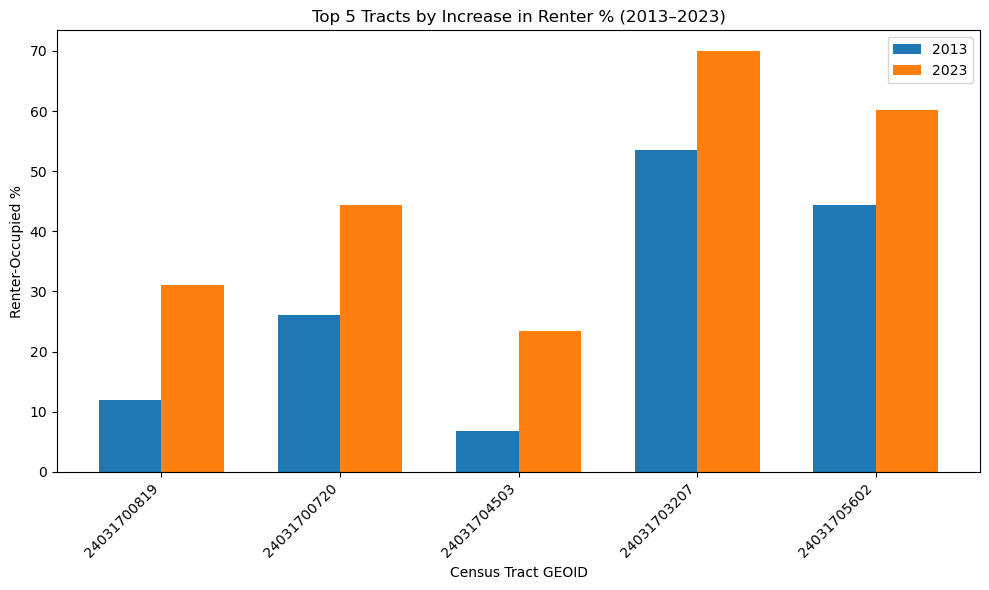

In [19]:
# CREATING A BAR GRAPH

import pandas as pd
import matplotlib.pyplot as plt

# Load tenure_merged if not already loaded
# tenure_merged is assumed to already exist

# Select top 5 tracts by renter % increase
top5_renter = tenure_merged.sort_values("RenterChangePct", ascending=False).head(5)

# Bar chart setup
fig, ax = plt.subplots(figsize=(10, 6))
bar_width = 0.35
index = range(len(top5_renter))

# Plot bars for 2013 and 2023
bars1 = ax.bar(index, top5_renter["RenterPct_2013"], bar_width, label='2013')
bars2 = ax.bar(
    [i + bar_width for i in index],
    top5_renter["RenterPct_2023"],
    bar_width,
    label='2023'
)

# Formatting
ax.set_xlabel("Census Tract GEOID")
ax.set_ylabel("Renter-Occupied %")
ax.set_title("Top 5 Tracts by Increase in Renter % (2013–2023)")
ax.set_xticks([i + bar_width / 2 for i in index])
ax.set_xticklabels(top5_renter["GEOID"], rotation=45, ha='right')
ax.legend()

plt.tight_layout()
plt.savefig("output/07_renter_change_top5_graph.png", dpi=300, bbox_inches="tight")
plt.show()


### Now creating an Owner vs. Renter Ratio Map

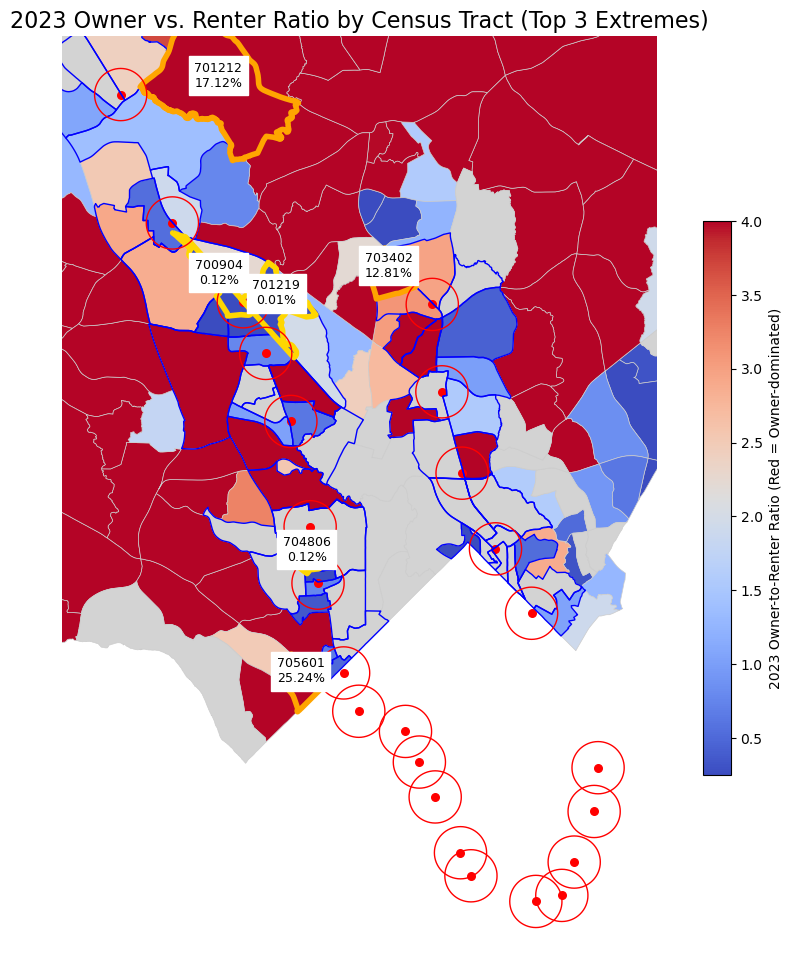

In [20]:
# Owner vs. Renter Ratio Map (2023)

import geopandas as gpd
import matplotlib.pyplot as plt

# Step 0: Rebuild map_df from base census tracts
map_df = census_tracts.copy()
map_df["GEOID"] = map_df["GEOID"].astype(str).str.zfill(11)
tenure_merged["GEOID"] = tenure_merged["GEOID"].astype(str).str.zfill(11)

# Step 1: Merge renter % data
map_df = map_df.merge(
    tenure_merged[["GEOID", "RenterPct_2023"]],
    on="GEOID", how="left"
)

# Step 2: Calculate ownership and ratio
map_df["OwnerPct_2023"] = 100 - map_df["RenterPct_2023"]
map_df["OwnerRenterRatio_2023"] = map_df["OwnerPct_2023"] / map_df["RenterPct_2023"]

# Step 3: CRS alignment 
map_df = map_df.to_crs(epsg=26985)
tracts_near_red_line = tracts_near_red_line.to_crs(epsg=26985)
red_line_stations = red_line_stations.to_crs(epsg=26985)
red_line_buffers = red_line_buffers.to_crs(epsg=26985)

# Step 4: Identify top/bottom tracts near Red Line
tracts_near_red_line["GEOID"] = tracts_near_red_line["GEOID20"].astype(str).str.zfill(11)
buffer_tracts = map_df[map_df["GEOID"].isin(tracts_near_red_line["GEOID"])]

top_owners = buffer_tracts.nlargest(3, "OwnerRenterRatio_2023")
top_renters = buffer_tracts.nsmallest(3, "OwnerRenterRatio_2023")

# Step 5: Plot
fig, ax = plt.subplots(figsize=(12, 12))
map_df.plot(
    column="OwnerRenterRatio_2023",
    cmap="coolwarm",
    linewidth=0.5,
    edgecolor="0.8",
    ax=ax,
    legend=True,
    vmin=0.25,
    vmax=4.0,
    legend_kwds={
        "label": "2023 Owner-to-Renter Ratio (Red = Owner-dominated)",
        "shrink": 0.6
    },
    missing_kwds={"color": "lightgrey", "label": "No data"},
)

# Step 6: Red Line overlays
red_line_buffers.boundary.plot(ax=ax, color='red', linewidth=1)
red_line_stations.plot(ax=ax, color='red', markersize=30)
tracts_near_red_line.plot(ax=ax, facecolor='none', edgecolor='blue', linewidth=1)

# Step 7: Highlight extreme tracts
top_owners.plot(ax=ax, facecolor='none', edgecolor='orange', linewidth=4)
top_renters.plot(ax=ax, facecolor='none', edgecolor='gold', linewidth=4)

# Step 8: Labels
if 'label_tracts' in globals():
    label_tracts(ax, top_owners, value_col="OwnerRenterRatio_2023")
    label_tracts(ax, top_renters, value_col="OwnerRenterRatio_2023")

# Step 9: Zoom to corridor
bounds = red_line_buffers.total_bounds
buffer = 1000
ax.set_xlim(bounds[0] - buffer, bounds[2] + buffer)
ax.set_ylim(bounds[1] - buffer, bounds[3] + buffer)

# Step 10: Final formatting
ax.set_title("2023 Owner vs. Renter Ratio by Census Tract (Top 3 Extremes)", fontsize=16)
ax.axis("off")

plt.savefig("output/08_owner_renter_ratio_2023.png", dpi=300, bbox_inches="tight")
plt.show()


### # Finally, we can upload, clean, and visualize 2013 and 2023 racial demographic data

In [21]:
def clean_race_data(df, year):
    df = df.rename(columns={df.columns[0]: "Label"})

    # Keep only Estimate columns (ignore Margin of Error)
    estimate_cols = [col for col in df.columns if "!!Estimate" in col]
    df = df[["Label"] + estimate_cols]

    # Melt to long format
    df_long = df.melt(id_vars="Label", var_name="Tract", value_name="Estimate")
    df_long["Estimate"] = df_long["Estimate"].astype(str).str.replace(",", "").astype(float)

    # Extract Tract number and convert to full GEOID
    df_long["Tract_Number"] = df_long["Tract"].str.extract(r'Census Tract ([\d\.]+)')[0]
    df_long["GEOID"] = "24031" + df_long["Tract_Number"].str.replace(".", "", regex=False).str.zfill(6)

    # Standardize label names
    rename_dict = {
        "Total:": "Total",
        "White alone": "White",
        "Black or African American alone": "Black",
        "Hispanic or Latino:": "Hispanic"
    }
    df_long["Label"] = df_long["Label"].str.strip().replace(rename_dict)

    # Pivot to wide format
    df_pivot = df_long.pivot_table(index="GEOID", columns="Label", values="Estimate", aggfunc="sum").reset_index()

    # Check for required columns
    required = ["Total", "White", "Black", "Hispanic"]
    missing = [col for col in required if col not in df_pivot.columns]
    if missing:
        print(f"Missing required columns: {missing}")
        return None

    # Calculate percent columns
    df_pivot[f"Pct_White_{year}"] = df_pivot["White"] / df_pivot["Total"] * 100
    df_pivot[f"Pct_Black_{year}"] = df_pivot["Black"] / df_pivot["Total"] * 100
    df_pivot[f"Pct_Hispanic_{year}"] = df_pivot["Hispanic"] / df_pivot["Total"] * 100

    return df_pivot[["GEOID", f"Pct_White_{year}", f"Pct_Black_{year}", f"Pct_Hispanic_{year}"]]


In [22]:
race_2013 = pd.read_csv("Census_Data/2013_HispanicOrLatino.csv")
race_2023 = pd.read_csv("Census_Data/2023_HispanicOrLatino.csv")

race13_clean = clean_race_data(race_2013, 2013)
race23_clean = clean_race_data(race_2023, 2023)


In [23]:
race_merged = race13_clean.merge(race23_clean, on="GEOID", how="inner")

race_merged["White_Change_Pct"] = race_merged["Pct_White_2023"] - race_merged["Pct_White_2013"]
race_merged["Black_Change_Pct"] = race_merged["Pct_Black_2023"] - race_merged["Pct_Black_2013"]
race_merged["Hispanic_Change_Pct"] = race_merged["Pct_Hispanic_2023"] - race_merged["Pct_Hispanic_2013"]


In [24]:
master_df = pd.read_csv("Final_Tract-Level_Percent_Changes_Updated.csv")
master_df["GEOID"] = master_df["GEOID"].astype(str).str.zfill(11)
race_merged["GEOID"] = race_merged["GEOID"].astype(str).str.zfill(11)

final_df = master_df.merge(race_merged, on="GEOID", how="left")
final_df.to_csv("Final_Master_Spreadsheet.csv", index=False)


### We can visualize change in Hispanic population percentage first

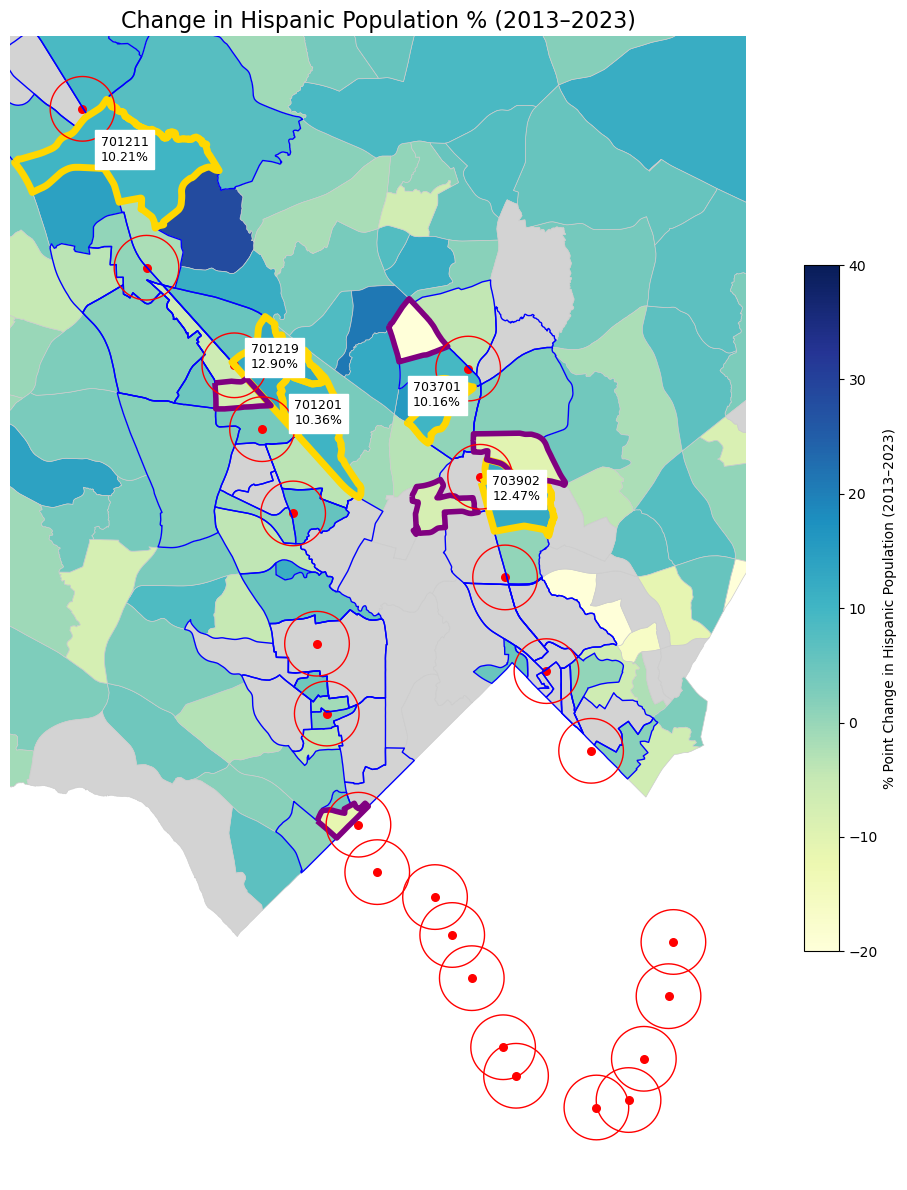

In [25]:
if "Hispanic_Change_Pct" in map_df.columns:
    map_df = map_df.drop(columns=["Hispanic_Change_Pct"])

# Step 0: Join Hispanic % change into map_df
map_df["GEOID"] = map_df["GEOID"].astype(str).str.zfill(11)
map_df = map_df.merge(race_merged[["GEOID", "Hispanic_Change_Pct"]], on="GEOID", how="left")

# Step 1: Ensure tracts_near_red_line GEOIDs match
tracts_near_red_line["GEOID"] = tracts_near_red_line["GEOID20"].astype(str).str.zfill(11)

# Step 2: Filter buffer-zone tracts
buffer_tracts = map_df[map_df["GEOID"].isin(tracts_near_red_line["GEOID"])]

# Step 3: Identify top/bottom 5 tracts by Hispanic % change
top_hispanic = buffer_tracts.nlargest(5, "Hispanic_Change_Pct")
bottom_hispanic = buffer_tracts.nsmallest(5, "Hispanic_Change_Pct")

# Step 4: Extract full geometry for highlighting
top_tracts = map_df[map_df["GEOID"].isin(top_hispanic["GEOID"])]
bottom_tracts = map_df[map_df["GEOID"].isin(bottom_hispanic["GEOID"])]

# Step 5: Plot base choropleth
fig, ax = plt.subplots(figsize=(12, 12))
map_df.plot(
    column="Hispanic_Change_Pct",
    cmap="YlGnBu",  # Yellow = decrease, Blue = strong increase
    linewidth=0.5,
    ax=ax,
    edgecolor="0.8",
    legend=True,
    vmin=-20,
    vmax=40,
    legend_kwds={"label": "% Point Change in Hispanic Population (2013–2023)", "shrink": 0.6},
    missing_kwds={"color": "lightgrey", "label": "No data"},
)

# Step 6: Red Line overlays
map_df = map_df.to_crs(red_line_stations.crs)
if 'red_line_buffers' in locals():
    red_line_buffers.boundary.plot(ax=ax, color='red', linewidth=1)
if 'red_line_stations' in locals():
    red_line_stations.plot(ax=ax, color='red', markersize=30)
if 'tracts_near_red_line' in locals():
    tracts_near_red_line.plot(ax=ax, facecolor='none', edgecolor='blue', linewidth=1)

# Step 7: Highlight extremes
top_tracts.plot(ax=ax, facecolor='none', edgecolor='gold', linewidth=5)
bottom_tracts.plot(ax=ax, facecolor='none', edgecolor='purple', linewidth=4)

# Step 8: Labeling
if 'label_tracts' in globals():
    label_tracts(ax, top_tracts, value_col="Hispanic_Change_Pct")

# Step 9: Zoom to Red Line corridor
bounds = red_line_buffers.total_bounds
buffer = 1000
ax.set_xlim(bounds[0] - buffer, bounds[2] + buffer)
ax.set_ylim(bounds[1] - buffer, bounds[3] + buffer)

# Step 10: Final polish
ax.set_title("Change in Hispanic Population % (2013–2023)", fontsize=16)
ax.axis("off")
plt.tight_layout()
plt.savefig("output/09_hispanic_change_percent.png", dpi=300, bbox_inches="tight")
plt.show()


### ... and identify the five tracts that saw the most extreme decrease in Hispanic population percentage

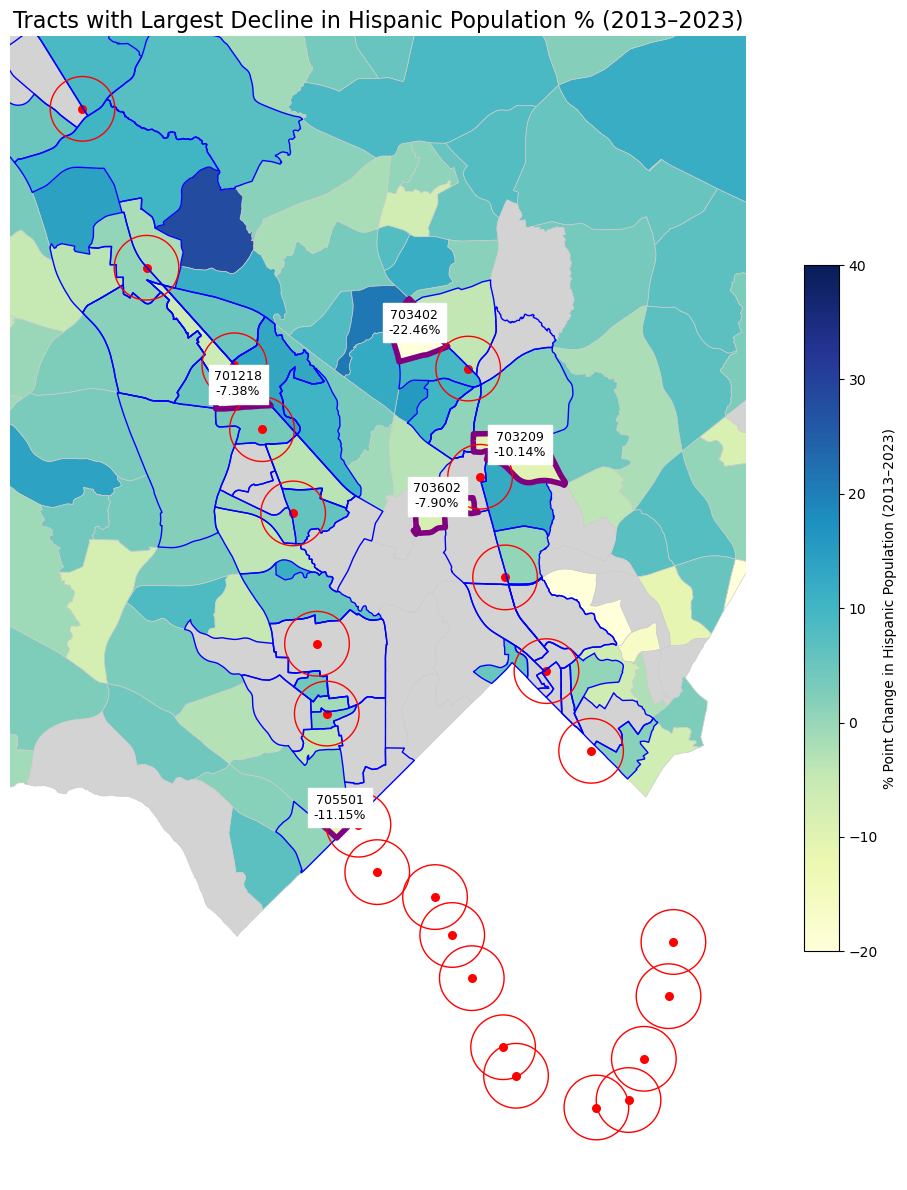

In [26]:
# Step 0: Drop and re-merge Hispanic change data if needed
if "Hispanic_Change_Pct" in map_df.columns:
    map_df = map_df.drop(columns=["Hispanic_Change_Pct"])

map_df = map_df.merge(race_merged[["GEOID", "Hispanic_Change_Pct"]], on="GEOID", how="left")

# Step 1: Clean GEOIDs
tracts_near_red_line["GEOID"] = tracts_near_red_line["GEOID20"].astype(str).str.zfill(11)

# Step 2: Filter to buffer-zone tracts
buffer_tracts = map_df[map_df["GEOID"].isin(tracts_near_red_line["GEOID"])]

# Step 3: Identify bottom 5 tracts by Hispanic % change
bottom_hispanic = buffer_tracts.nsmallest(5, "Hispanic_Change_Pct")

# Step 4: Extract full geometry for highlighting
bottom_tracts = map_df[map_df["GEOID"].isin(bottom_hispanic["GEOID"])]

# Step 5: Plot base choropleth
fig, ax = plt.subplots(figsize=(12, 12))
map_df.plot(
    column="Hispanic_Change_Pct",
    cmap="YlGnBu",
    linewidth=0.5,
    ax=ax,
    edgecolor="0.8",
    legend=True,
    vmin=-20,
    vmax=40,
    legend_kwds={"label": "% Point Change in Hispanic Population (2013–2023)", "shrink": 0.6},
    missing_kwds={"color": "lightgrey", "label": "No data"},
)

# Step 6: Red Line overlays
map_df = map_df.to_crs(red_line_stations.crs)
if 'red_line_buffers' in locals():
    red_line_buffers.boundary.plot(ax=ax, color='red', linewidth=1)
if 'red_line_stations' in locals():
    red_line_stations.plot(ax=ax, color='red', markersize=30)
if 'tracts_near_red_line' in locals():
    tracts_near_red_line.plot(ax=ax, facecolor='none', edgecolor='blue', linewidth=1)

# Step 7: Callouts (just the bottom 5)
bottom_tracts.plot(ax=ax, facecolor='none', edgecolor='purple', linewidth=4)

# Step 8: Labels
if 'label_tracts' in globals():
    label_tracts(ax, bottom_tracts, value_col="Hispanic_Change_Pct")

# Step 9: Zoom to corridor
bounds = red_line_buffers.total_bounds
buffer = 1000
ax.set_xlim(bounds[0] - buffer, bounds[2] + buffer)
ax.set_ylim(bounds[1] - buffer, bounds[3] + buffer)

# Step 10: Final polish
ax.set_title("Tracts with Largest Decline in Hispanic Population % (2013–2023)", fontsize=16)
ax.axis("off")
plt.tight_layout()
plt.savefig("output/10_hispanic_change_percent.png", dpi=300, bbox_inches="tight")
plt.show()


### Taking a look at changes in white and black population percentages while we're here

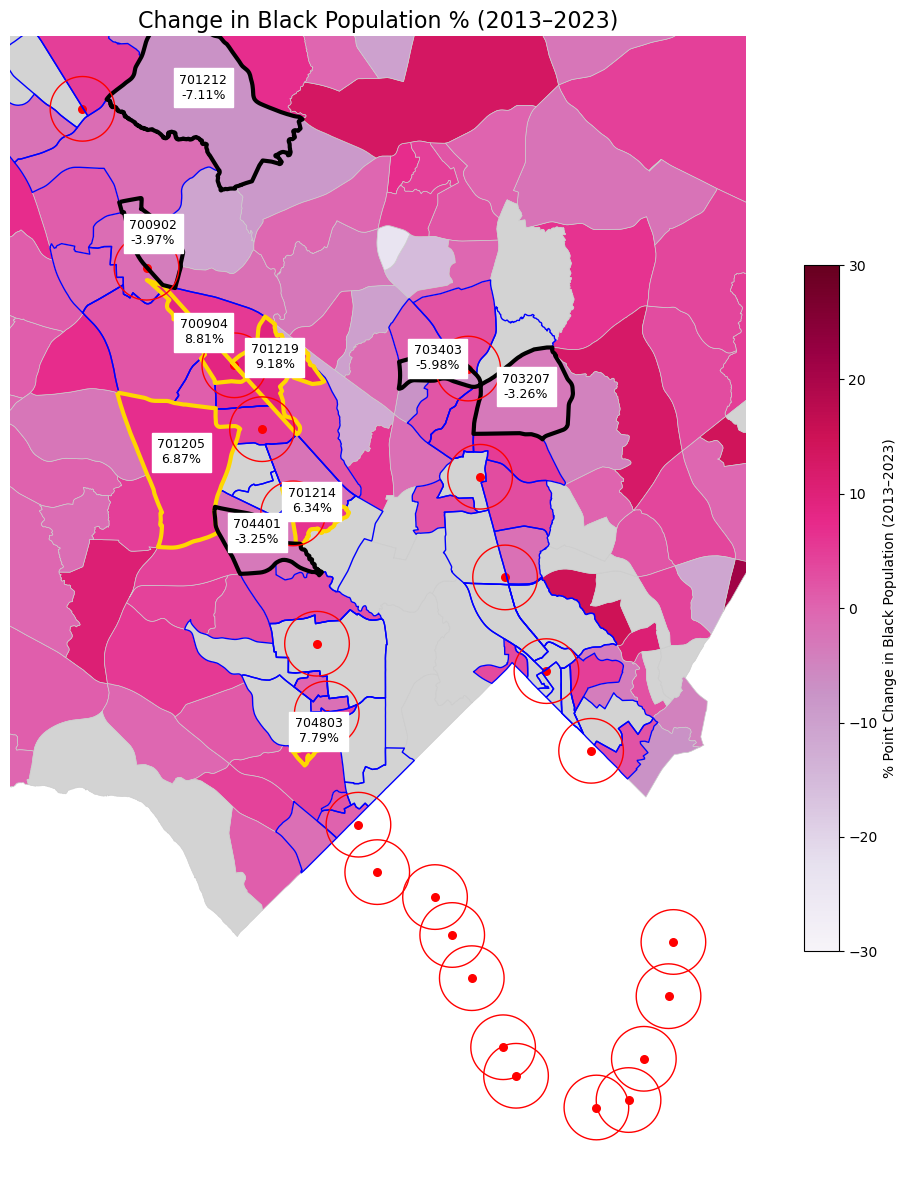

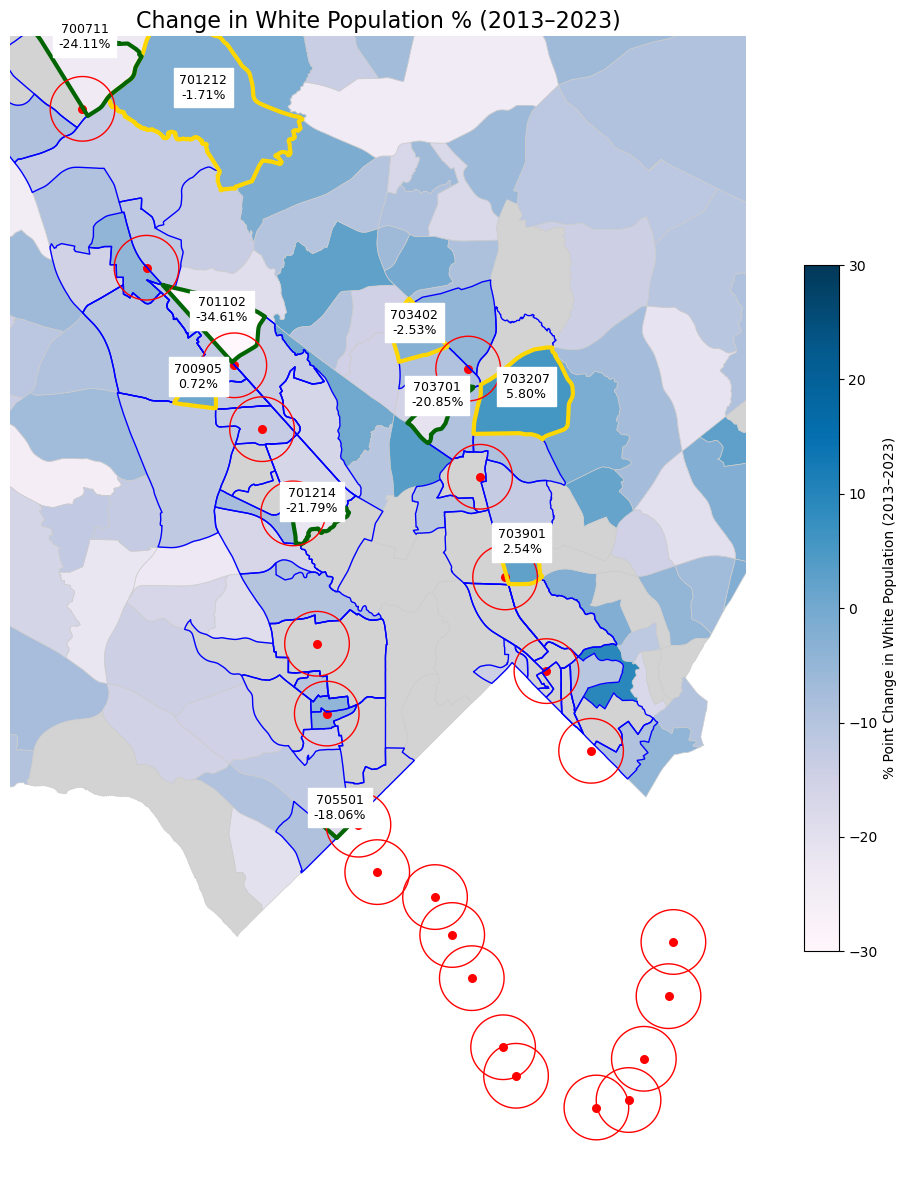

In [27]:
for group, color, edge_color, title in [
    ("Black_Change_Pct", "PuRd", "black", "Change in Black Population % (2013–2023)"),
    ("White_Change_Pct", "PuBu", "darkgreen", "Change in White Population % (2013–2023)")
]:
    # Drop and re-merge if needed
    if group in map_df.columns:
        map_df = map_df.drop(columns=[group])
    map_df = map_df.merge(race_merged[["GEOID", group]], on="GEOID", how="left")

    # Filter to buffer tracts
    buffer_tracts = map_df[map_df["GEOID"].isin(tracts_near_red_line["GEOID"])]

    # Top 5 gain and loss tracts
    top_5 = buffer_tracts.nlargest(5, group)
    bottom_5 = buffer_tracts.nsmallest(5, group)
    top_tracts = map_df[map_df["GEOID"].isin(top_5["GEOID"])]
    bottom_tracts = map_df[map_df["GEOID"].isin(bottom_5["GEOID"])]

    # Plot map
    fig, ax = plt.subplots(figsize=(12, 12))
    map_df.plot(
        column=group,
        cmap=color,
        linewidth=0.5,
        ax=ax,
        edgecolor="0.8",
        legend=True,
        vmin=-30,
        vmax=30,
        legend_kwds={"label": f"% Point Change in {group.split('_')[0]} Population (2013–2023)", "shrink": 0.6},
        missing_kwds={"color": "lightgrey", "label": "No data"},
    )

    # Overlays
    map_df = map_df.to_crs(red_line_stations.crs)
    if 'red_line_buffers' in locals():
        red_line_buffers.boundary.plot(ax=ax, color='red', linewidth=1)
    if 'red_line_stations' in locals():
        red_line_stations.plot(ax=ax, color='red', markersize=30)
    if 'tracts_near_red_line' in locals():
        tracts_near_red_line.plot(ax=ax, facecolor='none', edgecolor='blue', linewidth=1)

    # Highlight extreme tracts
    top_tracts.plot(ax=ax, facecolor='none', edgecolor='gold', linewidth=3)
    bottom_tracts.plot(ax=ax, facecolor='none', edgecolor=edge_color, linewidth=3)

    # Labels
    if 'label_tracts' in globals():
        label_tracts(ax, top_tracts, value_col=group)
        label_tracts(ax, bottom_tracts, value_col=group)

    # Zoom to corridor
    bounds = red_line_buffers.total_bounds
    buffer = 1000
    ax.set_xlim(bounds[0] - buffer, bounds[2] + buffer)
    ax.set_ylim(bounds[1] - buffer, bounds[3] + buffer)

    # Title and cleanup
    ax.set_title(title, fontsize=16)
    ax.axis("off")
    plt.tight_layout()
    plt.show()


### The End... for now. 